## Extractive Summarization - Tensorflow 2.0

In this notebook, we provide an implementation for training an extractive text summarization model. The overall goal is to "score" each sentence in a passage where the score represents the likelihood that the sentence belongs in a summary.


## Dataset

We will use the CNN/Dailymail dataset (contains articles and human written highlights) which has been preprocessed in the following way

- Each sentence in each article (extracted using a large Spacy LM) is assigned a label (0: not in summary, 1: in summary). Since CNN/DailyMail highlights dont contain exact extracts, the label is generatedd based on max Rogue score between sentence and each sentence in highlights. See data preprocesssing notebook for details.
- Data is undersampled to reduce class imbalance 

## Problem Formulation and Model 

We treat this as a sentence classification problem where the goal is to classify each sentence in a document as belonging to a summary or not, given the document (or portions of the document) 

- Model Input: a sentence, and the entire document 
- Model Output: A score representing likelihood of belonging in the summary or not. 

## Implementation 

- We use sentence bert models to get representations for our text. We use the smallest model (sentence-transformers/paraphrase-MiniLM-L3-v2), but this can be replaced by a larger more accurate model. See the list of sentence bert pretrained  [models](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models).
- Representations for sentence and document are concatenated and fed to a Dense layer and then predictions.

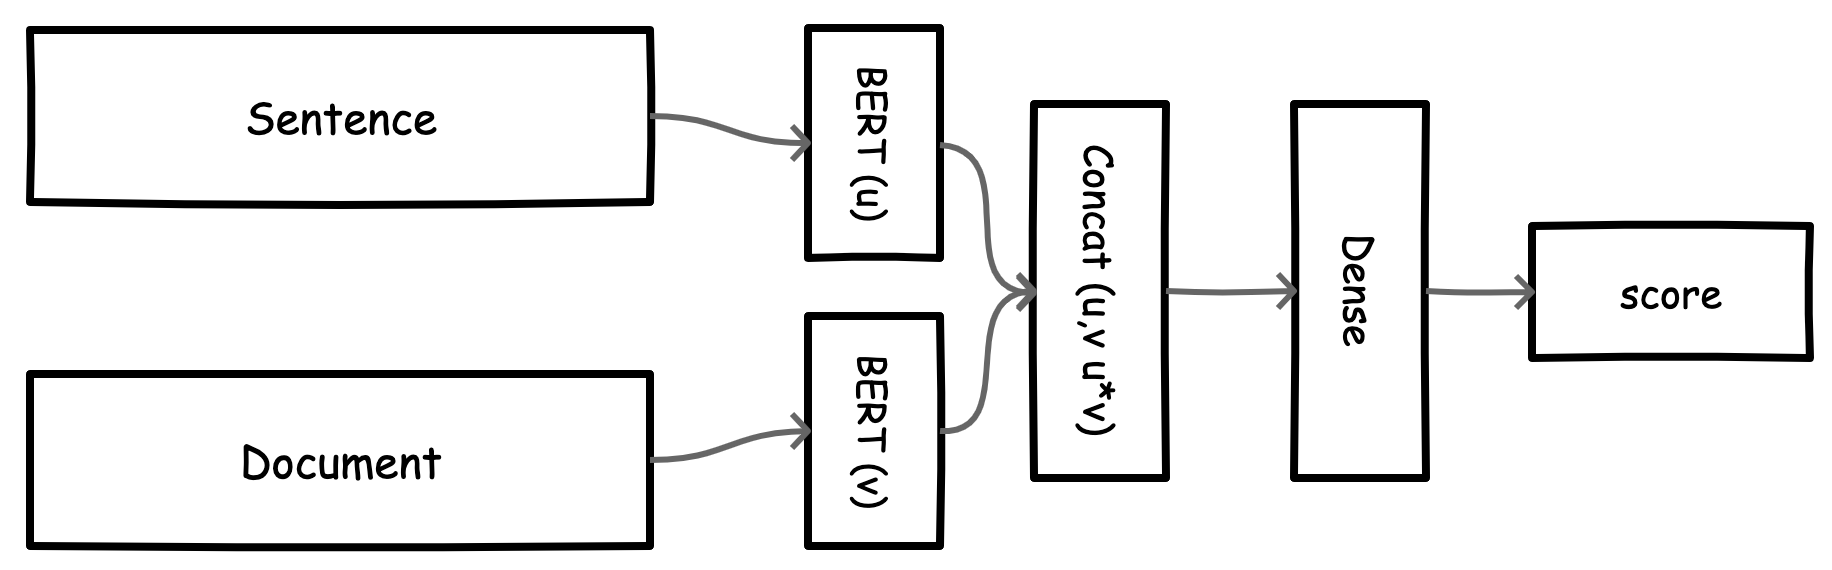

In [22]:
# !pip install -q transformers  rouge-score  

In [23]:
import os 
import numpy as np
 
import pandas as pd 
import transformers 

In [24]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os 
  
sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/" # location to store and load models 

In [25]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05 

# load dataframes containining preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json(sum_dir + "data/train_bdf.json")
test_df = pd.read_json(sum_dir +"data/test_bdf.json") 
print( "Train, test shape", train_df.shape, test_df.shape)

Train, test shape (687975, 3) (33702, 3)


## Create a Data Loader Class 

- Create a dataloader class that yields sentences and documentss and labels.

In [28]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [43]:
for index in range(len(train_df)):
      sentence = str(train_df.iloc[index].sents)
      sentence = " ".join(sentence.split())

      document = str(train_df.iloc[index].docs)
      document = " ".join(document.split())

      y = train_df.iloc[index].y 
      print(sentence, document, y)
      break

The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The di

In [44]:
batch_size = 32

 
def train_generator():
    for index in range(len(train_df)):
      sentence = str(train_df.iloc[index].sents)
      sentence = " ".join(sentence.split())

      document = str(train_df.iloc[index].docs)
      document = " ".join(document.split())

      y = train_df.iloc[index].y

      yield {"sentence": sentence, "document": document}, y
def test_generator():
    for index in range(len(test_df)):
      sentence = str(test_df.iloc[index].sents)
      sentence = " ".join(sentence.split())

      document = str(test_df.iloc[index].docs)
      document = " ".join(document.split())

      y = test_df.iloc[index].y

      yield {"sentence": sentence, "document": document}, y

auto = tf.data.AUTOTUNE

In [45]:
train_ds = tf.data.Dataset.from_generator(train_generator, 
                                          output_signature=({"sentence": tf.TensorSpec(shape=(None), dtype=tf.string, name="sentence"), 
                                                             "document": tf.TensorSpec(shape=(None), dtype=tf.string, name="document")}, 
                                                           tf.TensorSpec(shape=(None), dtype=tf.int64, name="label"))
                                          )
train_ds = train_ds.batch(batch_size).prefetch(auto)


In [47]:
val_ds = tf.data.Dataset.from_generator(test_generator,  output_signature=({"sentence": tf.TensorSpec(shape=(None), dtype=tf.string, name="sentence"), 
                                                             "document": tf.TensorSpec(shape=(None), dtype=tf.string, name="document")}, 
                                                           tf.TensorSpec(shape=(None), dtype=tf.int64, name="label")),
                                         
                                          )
val_ds = val_ds.batch(batch_size).prefetch(auto)

In [ ]:
for x,y in train_ds.take(1):
  print(x)

## Build Model 

- Build model based on Universal Sentence Encoder Model.

In [48]:
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt 

encoding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',  trainable=True, name="embedding")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [51]:
def get_model():
  input_a = keras.Input(shape=[] ,dtype=tf.string, name="sentence") 
  input_b = keras.Input(shape=[] ,dtype=tf.string, name="document") 

  embedding_a = encoding_layer(input_a)
  embedding_b = encoding_layer(input_b)

  combined = keras.layers.Multiply()([embedding_a,embedding_b])
  x = keras.layers.Concatenate(name="concat")([embedding_a, embedding_b, combined])

  x = keras.layers.Dense(512,activation='relu')(x) 
  output = keras.layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model([input_a, input_b], output, name="extractive_model") 
  tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True) 
  return model 

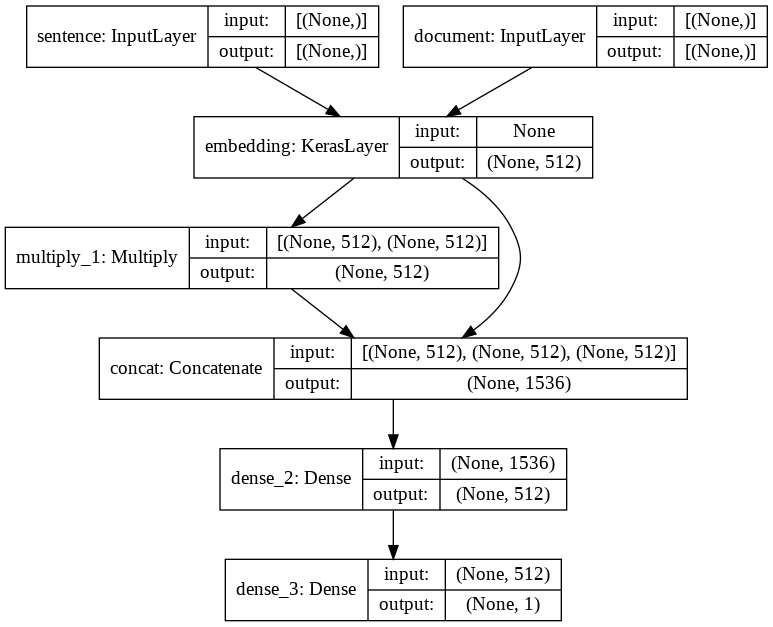

In [52]:
model = get_model()
Image("model.png")

In [53]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              # loss = "categorical_crossentropy" 
              # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()] 
              # metrics = ['accuracy']
              )


In [54]:
def plot_history(history, title=""): 
   
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  
  plt.show()

In [ ]:
history = model.fit(train_ds,
                     validation_data=val_ds, 
                     epochs=2
                    )

Epoch 1/2
   2622/Unknown - 510s 191ms/step - loss: 9.3788e-04 - binary_accuracy: 0.9998

## Save Model

In [ ]:
import os 

os.makedirs("models", exist_ok=True)

def save_model(name, model):
  print(">>> Saving model", name) 
  model_dir = "models/"+name
  tf.keras.models.save_model(model, model_dir, save_traces=True, include_optimizer=False) 


save_model("extractive_tf", model)
!gsutil cp -r models $sum_dir

# Conclusions 

The approach described above is a relatively untuned baseline. There are multiple opportunities for improvement. We can discuss a few below:

## Handling Data Imbalance :  
Given the nature of the task (selecting a small subset of sentences in a lengthy document), for most of the sentences we get from our training dataset, the vast majority will not belong to a summary. Class imbalance! 
 In this work, we used undersampling as a baseline strategy to handle class imbalance. A limitation of this approach is that we use a relatively small part of the total available data. We can explore other approaches that enable us to use most or all of our data. Weighted loss functions are recommended! 


## Sentencizer: 
Constructing our training dataset examples depends on the use of a sentencizer that converts documents to sentences which are used in constructing   training examples.  Similarly, at test time, a sentencizer is used to convert documents to sentences which are scored and used in the summary. A poor sentencizer (e.g. one that clips sentences midway) will make for summaries that are hard to read/follow. We found that using a large Spacy language model was a good starting point (the small model is not recommended). Bonus points for investing in a custom sentencizer that incorporates domain knowledge for your problem space. 


## Sentence and Document Representations: 

In this baseline, we use the Sentence Bert small model in deriving representations for sentences and documents. Other methods ( e.g. larger models) etc may provide improved results.  One thing to note is that while BERT based models will yield a representation for an arbitrarily sized document, in practice they are only using the first n tokens (where = maximum sequence length for the model which is usually 512 tokens). We also found that fine tuning the underlying BERT model on the extractive summarization task yielded significantly better results than using the BERT model as a simple feature extractor.


## Tuning Hyperparameters: 

A project like this has many obvious and non-obvious hyperparameters that could all be tuned. Beyond the choice of BERT model architecture and training parameters, we could also tune things like the label generation strategy, sentencizer, minimum sentence length to use in training/inference etc.
